# Ojective
To classify a given new review eithe positive or negative  using **Random forest trees and XGBoost tree classifier**  technqiue.

In [1]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Reading data

In [3]:
df=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/data.csv')
print(df.shape)
df.columns

(100000, 12)


Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'Class'],
      dtype='object')

# Train and test dataset
Dataset is diveided into two parts in which 67% data is train data and 33% of the data is test data which is used to validate the performance of the dataset

In [4]:
from sklearn.model_selection import train_test_split
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df['Text'],df['Class'],test_size=0.33,shuffle=False)
print(df_train_x.shape,df_test_x.shape,df_train_y.shape,df_test_y.shape)

(67000,) (33000,) (67000,) (33000,)


# read_table_data

In [0]:
import ast
from IPython.display import display, HTML
def read_table_data(filename):
    x=pd.read_csv(filename)
    trees=[]
    depth=[]
    learning_rate=[]
    cv_score=[]
    for x1 in x[['params','mean_test_score']].values:
       # print(x1)
       # print('************')
        a=ast.literal_eval(x1[0])
        cv_score.append(x1[1])
        trees.append(a['n_estimators'])
        depth.append(a['max_depth'])
        learning_rate.append(a['learning_rate'])
    results=pd.DataFrame({'trees':trees,'depth':depth,'cv_score':cv_score,'learning_rate':learning_rate})
    zz=results.sort_values(by=['cv_score','trees'],ascending=False)
    display(zz)

# Feature importance function

In [0]:
!pip install beautifultable
from beautifultable import BeautifulTable
def feature_importance(models_list,word_model):
  #words=[]
  index=0
  table=BeautifulTable()
  for model in models_list:
    scores=model.feature_importances_
    indices=np.argsort(scores)[-20:]
    words=[word_model.get_feature_names()[i] for i in np.argsort(scores)[-20:]]
    table.insert_column(index,"Important features model "+str(index),words)
    index=index+1
  print("Top 20 Important features")
  print(table)
  #print(words)
  

#  plot confusion matrix function

In [0]:
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score
def plot_confusion_matrix(output,df_test_y,name):
  import seaborn as sns
  from beautifultable import BeautifulTable
  table=BeautifulTable()
  table.insert_column(0,"precision_score",[precision_score(df_test_y,output)])
  table.insert_column(1,"recall_score",[recall_score(df_test_y,output)])
  table.insert_column(2,"accuracy",[accuracy_score(df_test_y,output)])
  table.insert_column(3,"f1-score",[f1_score(df_test_y,output)])
  print(table)
  cm_df = pd.DataFrame(confusion_matrix(df_test_y,output),index = ['negative','positive'], columns = ['negative','positive'])
  plt.figure(figsize=(5.5,4))
  sns.heatmap(cm_df, annot=True, fmt='g')
  plt.title('confusion matrix'+name)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# plot the table

In [0]:
from sklearn.metrics import f1_score,accuracy_score
def plot_table(depth,output,output1,output2):
  precision_scores=[];recall_scores=[];f1_scores=[];accuracies=[];
  outputs=[output,output1,output2]
  for item in outputs:
    precision_scores.append(precision_score(df_test_y,item))
    recall_scores.append(recall_score(df_test_y,item))
    f1_scores.append(f1_score(df_test_y,item))
    accuracies.append(accuracy_score(df_test_y,item))
  from beautifultable import BeautifulTable
  table=BeautifulTable()
  table.insert_column(0,"precision",precision_scores)
  table.insert_column(1,"recall",recall_scores)
  table.insert_column(2,"accuracy",accuracies)
  table.insert_column(3,"f1-score",f1_scores)
  table.insert_column(4,"depth",depth)
  sorted_table=table.sort('depth')
  print(table) 

# plot the grpah

In [0]:
def plot_graph(data,name):
  depth=data['depth']
  scores=data['scores']
  import matplotlib.pyplot as plt
  plt.xticks(range(1,30))
  plt.title(name)
  plt.xlabel('depth')
  plt.ylabel('accuracy')
  plt.plot(depth,scores)
  plt.show()

# random cv

In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
xclassifier = XGBClassifier()
def random_cv(train_data,df_train_y,filename):
  params = {  
    "n_estimators": range(100,1000,100),
    "max_depth": range(1,4),
    "learning_rate": np.linspace(0.3,0.1,10),
    #"colsample_bytree": one_to_left,
    #"subsample": one_to_left,
    #gamma": st.uniform(0, 10),
   # 'reg_alpha': from_zero_positive,
   # "min_child_weight": from_zero_positive,
  }
  random_cv=RandomizedSearchCV(xclassifier, params, scoring='f1', cv=3,return_train_score=True)
  result=random_cv.fit(train_data,df_train_y)
  x=pd.DataFrame(result.cv_results_)
  path="/content/drive/My Drive/Colab_Notebooks/rf_xgboost/xg_boost/"
  x.to_csv(path+filename)

# Bag of words - unigrams

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
bow_unigrams=CountVectorizer(stop_words='english')
BOW1_train=bow_unigrams.fit(df_train_x)
train_data=bow_unigrams.transform(df_train_x)
test_data=bow_unigrams.transform(df_test_x)
print("The train data shape is ",train_data.shape,"and test data shape is ",test_data.shape)

The train data shape is  (67000, 90770) and test data shape is  (33000, 90770)


In [0]:
from sklearn import preprocessing
bin=preprocessing.LabelEncoder()
df_train_y=bin.fit_transform(df_train_y)
df_test_y=bin.fit_transform(df_test_y)

In [0]:
from sklearn.ensemble import RandomForestClassifier
oob_scores=[];trees=[];depth=[]
for no_of_trees in range(1,100,10):
  trees.append(no_of_trees)
  for depth_max in range(1,100,10):
    depth.append(depth_max)
    rf=RandomForestClassifier(n_estimators=no_of_trees, criterion='gini', max_depth=depth_max, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
    radom_forest=rf.fit(train_data[:40000],df_train_y[:40000])
    oob_scores.append(radom_forest.oob_score_)

In [71]:
depth=[];trees=[]
for i in range(1,100,10):
  for j in range(1,100,10):
    depth.append(i)
    trees.append(j)
from beautifultable import BeautifulTable
table = BeautifulTable()
table.insert_column(0,"trees",trees)
table.insert_column(1,"depth",depth)
table.insert_column(2,"oob_score",oob_scores)
table.sort('oob_score',reverse=True)
print(table)

+-------+-------+-----------+
| trees | depth | oob_score |
+-------+-------+-----------+
|  71   |  91   |   0.909   |
+-------+-------+-----------+
|  81   |  81   |   0.908   |
+-------+-------+-----------+
|  91   |  61   |   0.907   |
+-------+-------+-----------+
|  91   |  81   |   0.907   |
+-------+-------+-----------+
|  91   |  91   |   0.907   |
+-------+-------+-----------+
|  81   |  71   |   0.907   |
+-------+-------+-----------+
|  81   |  91   |   0.907   |
+-------+-------+-----------+
|  91   |  71   |   0.906   |
+-------+-------+-----------+
|  71   |  81   |   0.906   |
+-------+-------+-----------+
|  81   |  61   |   0.904   |
+-------+-------+-----------+
|  61   |  91   |   0.903   |
+-------+-------+-----------+
|  61   |  81   |   0.903   |
+-------+-------+-----------+
|  71   |  71   |   0.903   |
+-------+-------+-----------+
|  91   |  51   |   0.903   |
+-------+-------+-----------+
|  71   |  61   |   0.902   |
+-------+-------+-----------+
|  81   | 

97


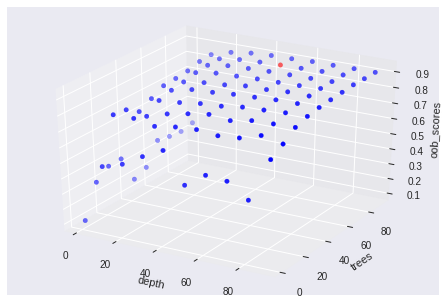

In [75]:
zmax= np.max(oob_scores)
print(np.argmax(oob_scores))
mask = np.array(oob_scores) ==  0.9018
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(depth, trees, oob_scores, color=color)
plt.ticklabel_format(useOffset=False)   
ax.set_xlabel('depth')
ax.set_ylabel('trees')
ax.set_zlabel('oob_scores')
plt.show()

**At the depth=41 and no.of trees=91 we are getting high oob_score around 90% so lets try these values on the test data.**

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=91, criterion='gini', max_depth=41, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
radom_forest=rf.fit(train_data,df_train_y)

In [0]:
output=radom_forest.predict(test_data)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.939      |    0.933     |  0.888   |  0.936   |
+-----------------+--------------+----------+----------+


/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


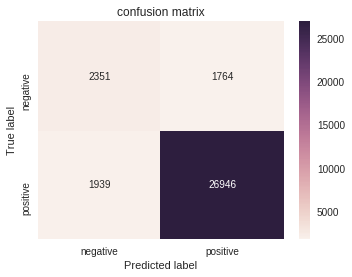

In [35]:
from sklearn.metrics import confusion_matrix
#!pip install beautifultable
plot_confusion_matrix(output,df_test_y,'')

In [36]:
feature_importance([radom_forest],bow_unigrams)

Top 20 Important features
+----------------------------+
| Important features model 0 |
+----------------------------+
|           waste            |
+----------------------------+
|            good            |
+----------------------------+
|          received          |
+----------------------------+
|            away            |
+----------------------------+
|           threw            |
+----------------------------+
|          product           |
+----------------------------+
|           loves            |
+----------------------------+
|            bad             |
+----------------------------+
|            easy            |
+----------------------------+
|          thought           |
+----------------------------+
|           awful            |
+----------------------------+
|            did             |
+----------------------------+
|           highly           |
+----------------------------+
|          perfect           |
+----------------------------+
|           m

In [20]:
#random_cv(train_data,df_train_y,"bow_unigrams.csv")
read_table_data('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/xg_boost/bow_unigrams.csv')

,cv_score,depth,learning_rate,trees
6,0.955640,3,0.211111,900
5,0.955060,3,0.188889,800
2,0.953935,3,0.233333,400
0,0.953092,3,0.166667,400
8,0.952967,2,0.277778,400
3,0.952921,1,0.300000,700
7,0.952731,2,0.188889,500
9,0.952222,1,0.277778,600
1,0.951382,2,0.277778,200
4,0.948133,1,0.233333,200


For depth=3 and no.of trees=900 we are getting an accuracy around 95% 

In [0]:
from xgboost.sklearn import XGBClassifier
xgb1 = XGBClassifier(learning_rate =0.2,n_estimators=900,max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,scale_pos_weight=1,)

In [0]:
xgb_model=xgb1.fit(train_data,df_train_y)

In [0]:
ouput=xgb_model.predict(test_data)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.923      |     0.98     |   0.91   |   0.95   |
+-----------------+--------------+----------+----------+


/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


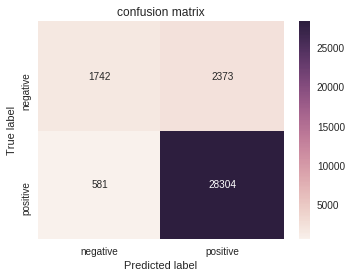

In [29]:
plot_confusion_matrix(ouput,df_test_y,'')

# Bag of words - Bigrams

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
bow_unigrams=CountVectorizer(ngram_range=(1,2),stop_words='english')
BOW1_train=bow_unigrams.fit(df_train_x)
train_data=bow_unigrams.transform(df_train_x)
test_data=bow_unigrams.transform(df_test_x)
print("The train data shape is ",train_data.shape,"and test data shape is ",test_data.shape)

The train data shape is  (67000, 1169770) and test data shape is  (33000, 1169770)


In [0]:
from sklearn.ensemble import RandomForestClassifier
oob_scores=[];trees=[];depth=[]
for no_of_trees in range(1,100,10):
  for depth_max in range(1,100,10):
    trees.append(no_of_trees)
    depth.append(depth_max)
    rf=RandomForestClassifier(n_estimators=no_of_trees, criterion='gini', max_depth=depth_max, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
    radom_forest=rf.fit(train_data,df_train_y)
    oob_scores.append(radom_forest.oob_score_)

In [0]:
depth=[];trees=[]
for i in range(1,100,10):
  for j in range(1,100,10):
    depth.append(i)
    trees.append(j)
    
bow_bigrams=pd.DataFrame({'depth':depth,'trees':trees,'oob_scores':oob_scores})
bow_bigrams.to_csv('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/bow_biigrams.csv')
from beautifultable import BeautifulTable
table = BeautifulTable()
table.insert_column(0,"trees",trees)
table.insert_column(1,"depth",depth)
table.insert_column(2,"oob_score",oob_scores)
table.sort('oob_score',reverse=True)

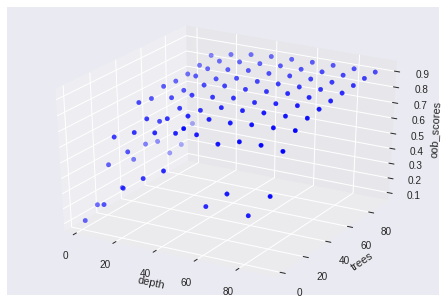

In [92]:
zmax= np.max(oob_scores)
mask = np.array(oob_scores) == 0.89698507
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(depth, trees, oob_scores, color=color)
plt.ticklabel_format(useOffset=False)   
ax.set_xlabel('depth')
ax.set_ylabel('trees')
ax.set_zlabel('oob_scores')
plt.show()

**At the tree depth=51 and no.of trees =91 we are getting accuracy around 90% , so lets try these values**

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=91, criterion='gini', max_depth=51, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
radom_forest=rf.fit(train_data,df_train_y)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   58.6s finished


+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.934      |    0.948     |  0.896   |  0.941   |
+-----------------+--------------+----------+----------+


/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


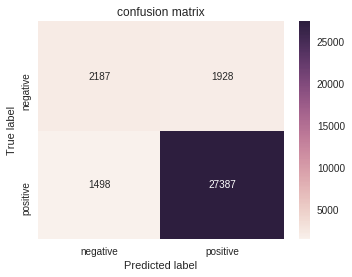

In [34]:
output=radom_forest.predict(test_data)
plot_confusion_matrix(output,df_test_y,'')

# xgboost

In [0]:
random_cv(train_data,df_train_y,"bow_bigrams.csv")

In [31]:
read_table_data('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/xg_boost/bow_bigrams.csv')

,cv_score,depth,learning_rate,trees
5,0.954179,3,0.211111,500
8,0.953783,3,0.122222,700
7,0.953485,3,0.166667,500
0,0.952790,2,0.233333,400
6,0.951873,1,0.255556,600
4,0.951382,2,0.100000,600
1,0.950237,1,0.277778,300
9,0.949958,1,0.166667,500
2,0.947672,1,0.144444,300
3,0.944207,1,0.122222,100


**The models precision score is around  94 and f1 score is  score is 83%**



In [0]:
from xgboost.sklearn import XGBClassifier
xgb1 = XGBClassifier(learning_rate =0.2,n_estimators=500,max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,scale_pos_weight=1,)

In [0]:
xgb_classifier=xgb1.fit(train_data,df_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.917      |    0.983     |  0.908   |  0.949   |
+-----------------+--------------+----------+----------+


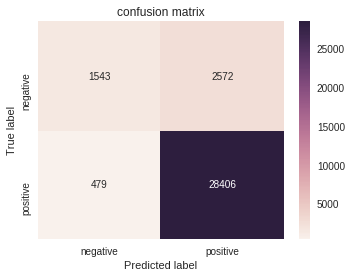

In [40]:
output=xgb_classifier.predict(test_data)
plot_confusion_matrix(output,df_test_y,'')

In [43]:
feature_importance([xgb_classifier],BOW1_train)

Top 20 Important features
+----------------------------+
| Important features model 0 |
+----------------------------+
|           flavor           |
+----------------------------+
|          ordered           |
+----------------------------+
|           didnt            |
+----------------------------+
|             im             |
+----------------------------+
|            try             |
+----------------------------+
|           tried            |
+----------------------------+
|            box             |
+----------------------------+
|           price            |
+----------------------------+
|            time            |
+----------------------------+
|           little           |
+----------------------------+
|           bought           |
+----------------------------+
|            best            |
+----------------------------+
|           really           |
+----------------------------+
|            dont            |
+----------------------------+
|           g

# Tf_idf Unigrams

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow_unigrams=TfidfVectorizer(stop_words='english')
tfidf1_train=bow_unigrams.fit(df_train_x)
train_data=bow_unigrams.transform(df_train_x)
test_data=bow_unigrams.transform(df_test_x)
print("The train data shape is ",train_data.shape,"and test data shape is ",test_data.shape)

The train data shape is  (67000, 90770) and test data shape is  (33000, 90770)


In [0]:
from sklearn.ensemble import RandomForestClassifier
oob_scores=[];trees=[];depth=[]
for no_of_trees in range(1,100,10):
  for depth_max in range(1,100,10):
    trees.append(no_of_trees)
    depth.append(depth_max)
    rf=RandomForestClassifier(n_estimators=no_of_trees, criterion='gini', max_depth=depth_max, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
    radom_forest=rf.fit(train_data,df_train_y)
    oob_scores.append(radom_forest.oob_score_)

In [97]:
depth=[];trees=[]
for i in range(1,100,10):
  for j in range(1,100,10):
    depth.append(i)
    trees.append(j)
tfidf_unigrams=pd.DataFrame({'depth':depth,'trees':trees,'oob_scores':oob_scores})
tfidf_unigrams.to_csv('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/tfidf_unigrams.csv')
from beautifultable import BeautifulTable
table = BeautifulTable()
table.insert_column(0,"trees",trees)
table.insert_column(1,"depth",depth)
table.insert_column(2,"oob_score",oob_scores)
table.sort('oob_score',reverse=True)
print(table)

+-------+-------+-----------+
| trees | depth | oob_score |
+-------+-------+-----------+
|  91   |  91   |   0.907   |
+-------+-------+-----------+
|  91   |  81   |   0.906   |
+-------+-------+-----------+
|  81   |  81   |   0.906   |
+-------+-------+-----------+
|  91   |  71   |   0.905   |
+-------+-------+-----------+
|  81   |  91   |   0.904   |
+-------+-------+-----------+
|  81   |  71   |   0.904   |
+-------+-------+-----------+
|  71   |  81   |   0.903   |
+-------+-------+-----------+
|  91   |  61   |   0.903   |
+-------+-------+-----------+
|  71   |  91   |   0.903   |
+-------+-------+-----------+
|  81   |  61   |   0.901   |
+-------+-------+-----------+
|  61   |  91   |    0.9    |
+-------+-------+-----------+
|  61   |  81   |    0.9    |
+-------+-------+-----------+
|  71   |  61   |    0.9    |
+-------+-------+-----------+
|  91   |  51   |    0.9    |
+-------+-------+-----------+
|  71   |  71   |   0.899   |
+-------+-------+-----------+
|  81   | 

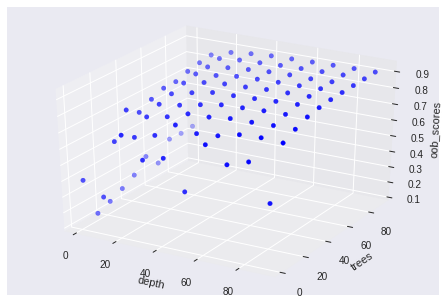

In [96]:
zmax= np.max(oob_scores)
mask = np.array(oob_scores) == 0.89698507
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(depth, trees, oob_scores, color=color)
plt.ticklabel_format(useOffset=False)   
ax.set_xlabel('depth')
ax.set_ylabel('trees')
ax.set_zlabel('oob_scores')
plt.show()

**For the no.of trees=91 and depth= 51 we are getting an accrracy around 90% so lets try out therse values on the test data**

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=91, criterion='gini', max_depth=51, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
radom_forest=rf.fit(train_data,df_train_y)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   22.8s finished


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  91 out of  91 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.93       |    0.955     |  0.898   |  0.942   |
+-----------------+--------------+----------+----------+


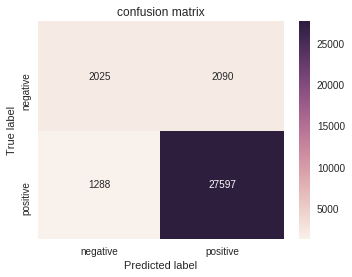

In [48]:
output=radom_forest.predict(test_data)
plot_confusion_matrix(output,df_test_y,'')

In [54]:
feature_importance([radom_forest],BOW1_train)

Top 20 Important features
+-----------------------------+
| Important features model 0  |
+-----------------------------+
|     best noncaffinated      |
+-----------------------------+
|        bald patches         |
+-----------------------------+
|      awaywilford voehl      |
+-----------------------------+
|          best mean          |
+-----------------------------+
|       actual dogbubba       |
+-----------------------------+
|      allergies summer       |
+-----------------------------+
|       amazon showing        |
+-----------------------------+
|            altar            |
+-----------------------------+
|         amazingyum          |
+-----------------------------+
|         actual pods         |
+-----------------------------+
|       allergies sense       |
+-----------------------------+
|      astounding month       |
+-----------------------------+
|    antioxidants perfect     |
+-----------------------------+
|       averaged priced       |
+-------------

xgboost

In [0]:
random_cv(train_data,df_train_y,"tf_idf_unigrams.csv")

In [45]:
read_table_data('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/xg_boost/tf_idf_unigrams.csv')

,cv_score,depth,learning_rate,trees
6,0.955287,3,0.211111,900
4,0.954892,3,0.233333,600
1,0.954149,3,0.144444,600
3,0.953955,2,0.277778,400
7,0.953735,3,0.100000,800
0,0.953496,1,0.233333,900
9,0.951866,1,0.211111,600
2,0.950537,1,0.166667,500
8,0.950153,1,0.100000,800
5,0.945391,1,0.188889,100


In [0]:
from xgboost.sklearn import XGBClassifier
xgb1 = XGBClassifier(learning_rate =0.2,n_estimators=900,max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,scale_pos_weight=1,)

In [0]:
xgb_classifier=xgb1.fit(train_data,df_train_y)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.923      |     0.98     |  0.911   |   0.95   |
+-----------------+--------------+----------+----------+


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


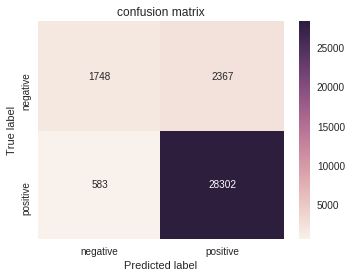

In [53]:
output=xgb_classifier.predict(test_data)
plot_confusion_matrix(output,df_test_y,'')

In [55]:
feature_importance([xgb_classifier],BOW1_train)

Top 20 Important features
+----------------------------+
| Important features model 0 |
+----------------------------+
|       better england       |
+----------------------------+
|       addicted pack        |
+----------------------------+
|    aftertaste delicious    |
+----------------------------+
|           add ms           |
+----------------------------+
|      allergies sense       |
+----------------------------+
|         arcata ca          |
+----------------------------+
|       best pricethe        |
+----------------------------+
|      assortment agree      |
+----------------------------+
|    access refrigeratora    |
+----------------------------+
|       asthma trigger       |
+----------------------------+
|        bar proteins        |
+----------------------------+
|        almond tarts        |
+----------------------------+
|       anythingi just       |
+----------------------------+
|     amazons reviewers      |
+----------------------------+
|   additiona

# TF-IDF bigrams

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow_unigrams=TfidfVectorizer(ngram_range=(1,2),stop_words='english')
tfidf1_train=bow_unigrams.fit(df_train_x)
train_data=bow_unigrams.transform(df_train_x)
test_data=bow_unigrams.transform(df_test_x)
print("The train data shape is ",train_data.shape,"and test data shape is ",test_data.shape)

The train data shape is  (67000, 1169770) and test data shape is  (33000, 1169770)


In [99]:
from sklearn.ensemble import RandomForestClassifier
oob_scores=[];trees=[];depth=[]
for no_of_trees in range(1,100,10):
  for depth_max in range(1,100,10):
    trees.append(no_of_trees)
    depth.append(depth_max)
    rf=RandomForestClassifier(n_estimators=no_of_trees, criterion='gini', max_depth=depth_max, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
    radom_forest=rf.fit(train_data,df_train_y)
    oob_scores.append(radom_forest.oob_score_)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:  2.8min finished


In [100]:
depth=[];trees=[]
for i in range(1,100,10):
  for j in range(1,100,10):
    depth.append(i)
    trees.append(j)
    
tfidf_Bigrams=pd.DataFrame({'depth':depth,'trees':trees,'oob_scores':oob_scores})
tfidf_Bigrams.to_csv('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/tfidf_Bigrams.csv')
from beautifultable import BeautifulTable
table = BeautifulTable()
table.insert_column(0,"trees",trees)
table.insert_column(1,"depth",depth)
table.insert_column(2,"oob_score",oob_scores)
table.sort('oob_score',reverse=True)
print(table)

+-------+-------+-----------+
| trees | depth | oob_score |
+-------+-------+-----------+
|  91   |  81   |   0.905   |
+-------+-------+-----------+
|  81   |  91   |   0.905   |
+-------+-------+-----------+
|  91   |  71   |   0.905   |
+-------+-------+-----------+
|  91   |  91   |   0.904   |
+-------+-------+-----------+
|  81   |  81   |   0.903   |
+-------+-------+-----------+
|  71   |  91   |   0.903   |
+-------+-------+-----------+
|  91   |  61   |   0.901   |
+-------+-------+-----------+
|  81   |  71   |    0.9    |
+-------+-------+-----------+
|  61   |  91   |   0.898   |
+-------+-------+-----------+
|  81   |  61   |   0.896   |
+-------+-------+-----------+
|  71   |  81   |   0.896   |
+-------+-------+-----------+
|  71   |  71   |   0.894   |
+-------+-------+-----------+
|  91   |  51   |   0.894   |
+-------+-------+-----------+
|  61   |  81   |   0.893   |
+-------+-------+-----------+
|  51   |  91   |   0.891   |
+-------+-------+-----------+
|  81   | 

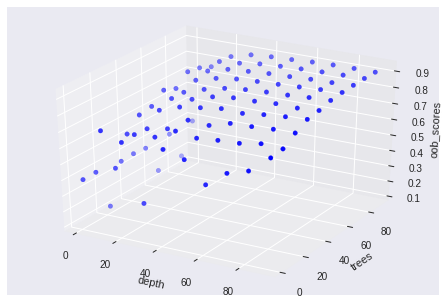

In [101]:

zmax= np.max(oob_scores)
mask = np.array(oob_scores) == 0.88
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(depth, trees, oob_scores, color=color)
plt.ticklabel_format(useOffset=False)   
ax.set_xlabel('depth')
ax.set_ylabel('trees')
ax.set_zlabel('oob_scores')
plt.show()

**At no.of tree=91    and depth= 31  we are getting an accuracy nearer to the 90%, so lets keep the these avalues evaluate the model performance on the test dataset.**


In [12]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=91, criterion='gini', max_depth=31, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
radom_forest=rf.fit(train_data,df_train_y)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   26.1s finished


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  91 out of  91 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.942      |    0.928     |  0.887   |  0.935   |
+-----------------+--------------+----------+----------+


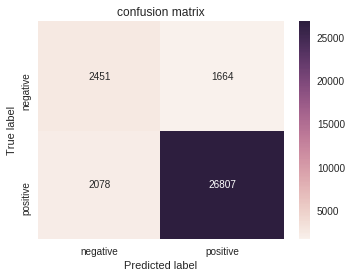

In [13]:
output=radom_forest.predict(test_data)
plot_confusion_matrix(output,df_test_y,'')

In [61]:
feature_importance([radom_forest],bow_unigrams)

Top 20 Important features
+----------------------------+
| Important features model 0 |
+----------------------------+
|         breakfast          |
+----------------------------+
|            rich            |
+----------------------------+
|            like            |
+----------------------------+
|       disappointment       |
+----------------------------+
|            nice            |
+----------------------------+
|            bad             |
+----------------------------+
|           bought           |
+----------------------------+
|          ordered           |
+----------------------------+
|         delicious          |
+----------------------------+
|           money            |
+----------------------------+
|          favorite          |
+----------------------------+
|          product           |
+----------------------------+
|          received          |
+----------------------------+
|           great            |
+----------------------------+
|           w

# xgboost

In [0]:
random_cv(train_data,df_train_y,"tf_idf_Bigrams.csv")

In [57]:
read_table_data('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/xg_boost/tf_idf_Bigrams.csv')

,cv_score,depth,learning_rate,trees
7,0.954658,2,0.255556,600
8,0.954262,2,0.166667,800
0,0.953879,2,0.233333,500
9,0.953831,3,0.100000,800
6,0.953138,2,0.211111,400
2,0.947522,1,0.122222,300
3,0.947374,1,0.166667,200
5,0.946911,2,0.144444,100
1,0.945354,1,0.100000,200
4,0.944288,1,0.122222,100


In [0]:
from xgboost.sklearn import XGBClassifier
xgb1 = XGBClassifier(learning_rate =0.25,n_estimators=600,max_depth=2,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,scale_pos_weight=1,)

In [0]:
xgb_classifier=xgb1.fit(train_data,df_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.923      |    0.977     |  0.908   |  0.949   |
+-----------------+--------------+----------+----------+


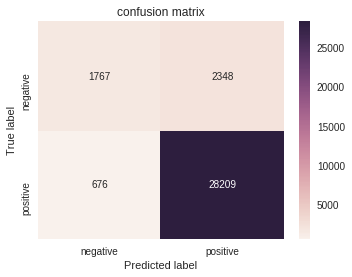

In [16]:
output=xgb1.predict(test_data)
plot_confusion_matrix(output,df_test_y,'')

In [17]:
feature_importance([xgb_classifier],bow_unigrams)

Top 20 Important features
+----------------------------+
| Important features model 0 |
+----------------------------+
|           amazon           |
+----------------------------+
|          terrible          |
+----------------------------+
|            buy             |
+----------------------------+
|         excellent          |
+----------------------------+
|            eat             |
+----------------------------+
|        disappointed        |
+----------------------------+
|         delicious          |
+----------------------------+
|            love            |
+----------------------------+
|            time            |
+----------------------------+
|           better           |
+----------------------------+
|           flavor           |
+----------------------------+
|           little           |
+----------------------------+
|            best            |
+----------------------------+
|            dont            |
+----------------------------+
|          pr

# word2vec model

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer 
tf_idf_model=TfidfVectorizer(stop_words='english')
stop_words = tf_idf_model.get_stop_words()
model=[]  
for sent in df_train_x:
    temp=[]
    for word in sent.split():
        if word not in stop_words:
            temp.append(word)
    model.append(temp)
print(model[0][0:10])

['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving']


In [0]:
!pip install gensim
from gensim.models import Word2Vec
amazon_model = Word2Vec(model, size=300, window=5, min_count=1, workers=4)

In [0]:
import numpy as np
word_vectors = amazon_model.wv
train_vec=[]
counter=0
for sentence in df_train_x:
    temp=np.zeros(300)
    length=0
    for word in sentence.split():
        if word in word_vectors:
            temp=temp+amazon_model.wv[word]
        else:
            #print(word," is not presnet in training model of word2vec")
            pass
        length+=1
    train_vec.append(temp/length)
    if(counter%10000==0):
        print(counter)
    counter+=1

In [0]:
import numpy as np
word_vectors = amazon_model.wv
test_vec=[]
counter=0
for sentence in df_test_x:
    temp=np.zeros(300)
    length=0
    for word in sentence.split():
        if word in word_vectors:
            temp=temp+amazon_model.wv[word]
        else:
            pass# print(word," is not presnet in training model of word2vec")
        length+=1
    test_vec.append(temp/length)
    if(counter%10000==0):
        print(counter)
    counter+=1

In [0]:
from sklearn.ensemble import RandomForestClassifier
oob_scores=[];trees=[];depth=[]
for no_of_trees in range(1,100,10):
  for depth_max in range(1,100,10):
    trees.append(no_of_trees)
    depth.append(depth_max)
    rf=RandomForestClassifier(n_estimators=no_of_trees, criterion='gini', max_depth=depth_max, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
    radom_forest=rf.fit(train_vec,df_train_y)
    oob_scores.append(radom_forest.oob_score_)

In [110]:
depth=[];trees=[]
for i in range(1,100,10):
  for j in range(1,100,10):
    depth.append(i)
    trees.append(j)
    
word2vec_vec=pd.DataFrame({'depth':depth,'trees':trees,'oob_scores':oob_scores})
word2vec_vec.to_csv('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/word2vec_vec.csv')
from beautifultable import BeautifulTable
table = BeautifulTable()
table.insert_column(0,"trees",trees)
table.insert_column(1,"depth",depth)
table.insert_column(2,"oob_score",oob_scores)
table.sort('oob_score',reverse=True)
print(table)

+-------+-------+-----------+
| trees | depth | oob_score |
+-------+-------+-----------+
|  31   |  81   |    0.9    |
+-------+-------+-----------+
|  31   |  91   |    0.9    |
+-------+-------+-----------+
|  31   |  71   |   0.899   |
+-------+-------+-----------+
|  61   |  81   |   0.899   |
+-------+-------+-----------+
|  31   |  61   |   0.899   |
+-------+-------+-----------+
|  41   |  91   |   0.899   |
+-------+-------+-----------+
|  61   |  91   |   0.899   |
+-------+-------+-----------+
|  61   |  71   |   0.899   |
+-------+-------+-----------+
|  31   |  51   |   0.899   |
+-------+-------+-----------+
|  71   |  71   |   0.899   |
+-------+-------+-----------+
|  91   |  81   |   0.899   |
+-------+-------+-----------+
|  81   |  81   |   0.899   |
+-------+-------+-----------+
|  81   |  91   |   0.899   |
+-------+-------+-----------+
|  21   |  91   |   0.899   |
+-------+-------+-----------+
|  51   |  81   |   0.899   |
+-------+-------+-----------+
|  81   | 

**At depth= 31  and no.of trees = 81 we are getting an accuracy about  90% so lets try these values on  the test to evaluate the performace of this model.  **

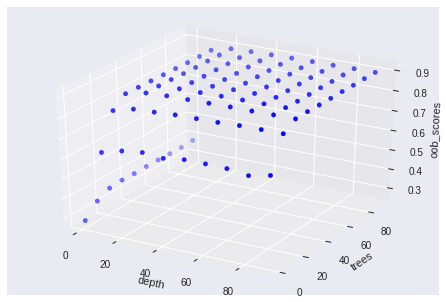

In [111]:
zmax= np.max(oob_scores)
mask = np.array(oob_scores) == 0.88
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(depth, trees, oob_scores, color=color)
plt.ticklabel_format(useOffset=False)   
ax.set_xlabel('depth')
ax.set_ylabel('trees')
ax.set_zlabel('oob_scores')
plt.show()

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=81, criterion='gini', max_depth=31, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=-1,  verbose=1, class_weight="balanced")
radom_forest=rf.fit(train_vec,df_train_y)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.3min finished


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.893      |    0.987     |  0.885   |  0.938   |
+-----------------+--------------+----------+----------+


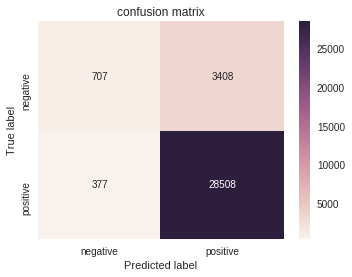

In [26]:
output=radom_forest.predict(test_vec)
plot_confusion_matrix(output,df_test_y,'')

# xgboost

In [0]:
#train_vec=np.array(train_vec)
random_cv(train_vec,df_train_y,"word2vec.csv")

In [27]:
read_table_data('/content/drive/My Drive/Colab_Notebooks/rf_xgboost/xg_boost/word2vec.csv')

,cv_score,depth,learning_rate,trees
5,0.948100,3,0.255556,100
2,0.947965,2,0.300000,400
0,0.947911,3,0.277778,800
4,0.947510,2,0.277778,100
6,0.947479,1,0.166667,500
9,0.947443,2,0.188889,100
1,0.947368,1,0.144444,700
3,0.947351,1,0.144444,600
8,0.947320,1,0.122222,500
7,0.946184,1,0.255556,100


In [0]:
from xgboost.sklearn import XGBClassifier
xgb1 = XGBClassifier(learning_rate =0.25,n_estimators=100,max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,scale_pos_weight=1,)

In [0]:
train_vec=np.array(train_vec)
xgb_classifier=xgb1.fit(train_vec,df_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.908      |    0.977     |  0.893   |  0.941   |
+-----------------+--------------+----------+----------+


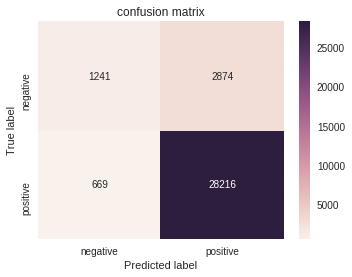

In [31]:
output=xgb_classifier.predict(test_vec)
plot_confusion_matrix(output,df_test_y,'')

# Feature importance in word2vec

**weights in word2vec model doesnot correspond to the actual words , so feature imortance in word2vec doesnot make sense.**

# Conclusion

**analyzed amazon fine food reviews dataset with ensemble techniques both eranodm forests and xtreme gradient boosted decison trees and tuned hyperparameter  with cross validation for diiferennt values cnd chosen best hyper parameters for all  vectorizations such as bag of words and tf_idf and word2vec and results are tabulated .**



**After analyzing random forest and xgboost  with all the vectorizations, all the model are perforing well and each f1 score is above 90% **